# Analysis of the HRS data using VARGLLVM

We want to analyse the HRS data using the VARGLLVM model.


 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable acpoisson for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$.

The dynamics of the latent variable over time is modelled through a stationary vector-autoregressive model of first order with trend


$$
z_{i,t} = \beta_0 + \beta_1 t + Az_{i,t-1} +  \epsilon_{i,t}\\
||A||_2 < 1\\
\epsilon_{i,t} \sim N(0, I)\\
$$

initialization for $t=0$:

$$
z_{i, 1} \sim N(0, \Sigma_{z1})\\
\Sigma_{z1} = 
\begin{pmatrix}
    \sigma_{z1,1}^2&\\
    &\sigma_{z1,2}^2
\end{pmatrix}\\
\sigma_{z1,i}>0 \forall i
$$

Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.


**For our initial model, we consider $\beta_0 = 0, \beta_1 = 0, z_{i1} =0$, and model the trend over time using (observed) covariates (namely using an intercept and the `age` variable).**

## Meeting 03.11.2023

TODO: only recall_immediate and recall_delayed (episodic memory)

later, maybe include the second latent variables representing the memory status (measured by the other ones)
estimate probability of observed response pattern vs the observed one 

implement stats in medicine

# Settings

In [100]:
import sys
sys.path.append("../../../VARGLLVM/")
import VARGLLVM
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR # scheduler
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import copy

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:500mb" # this ist to prevent cuda to reserve too much memory


# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Import the preprocessed data
data = np.load("../../../data/HRS/HRS_3Darray_innerjoin.npy")
data = data
print(data.shape)

CUDA is not available. Using CPU.
(6383, 15, 9)


In [101]:
names = [
    "age",
    "gender",
    "education",
    "month",
    "day",
    "year",
    "day_week",
    "paper",
    "cactus",
    "president",
    "vice_president",
    "serie_7",
    "backwards",
    "recall_immediate",
    "recall_delayed"
]

After discussing problems with Silvia, we decided to remove paper and cactus from the datasets.


In [102]:
# Create the backwards dummy
data[:,12] = data[:,12]>=1

In [103]:
# Transpose the data from (batch_length, num_features, seq_length) to  (batch_length, seq_length, num_features)
# Separate covariates and responses, and prepare the torch tensors
data = np.transpose(data, (0,2,1))

# Remove problematic variables cactus and paper

vars_to_remove = ["cactus", "paper"]  # in descending order
idx_to_remove = [names.index(var) for var in vars_to_remove]
idx_to_remove.sort(reverse=True)

for idx in idx_to_remove:
    data = np.delete(data, idx, axis=2)
    names.pop(idx)


In [104]:
print('Indices for the variables:')
for i, z in zip(names, range(len(names))):
    print(f'{z-3} : {i}')

Indices for the variables:
-3 : age
-2 : gender
-1 : education
0 : month
1 : day
2 : year
3 : day_week
4 : president
5 : vice_president
6 : serie_7
7 : backwards
8 : recall_immediate
9 : recall_delayed


# Computational Details

## Missing data
We now compute the proportion of missing data.

In [105]:
np.sum(np.isnan(data)) / np.prod(data.shape)

0.1779754181446176

And display its pattern (here for variable id 9).

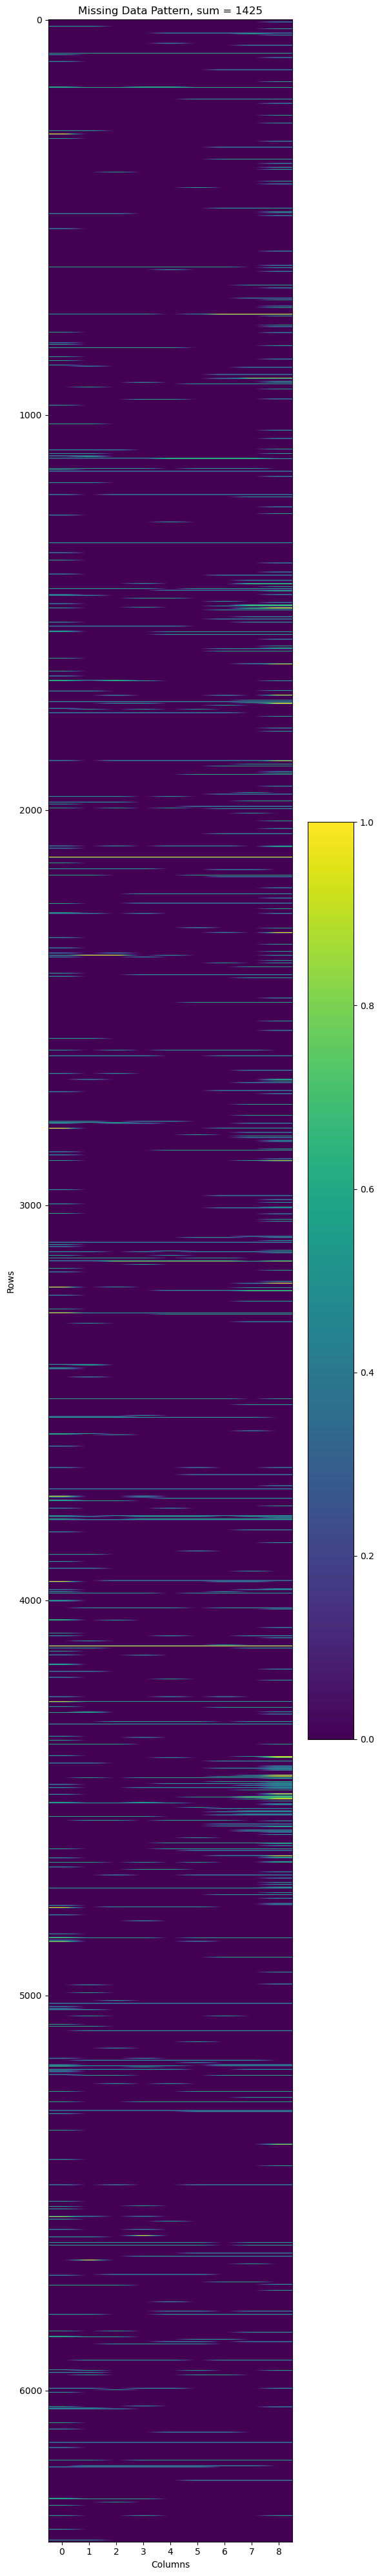

In [106]:
# Display the missing data pattern
i = 9
plt.figure(figsize=(6, 40))
plt.imshow(np.isnan(data[:,:,i]), cmap='viridis', aspect='auto')  # 'True' values will be shown in a distinct color
plt.colorbar()
plt.title(f'Missing Data Pattern, sum = {np.sum(np.isnan(data[:,:,i]))}')
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

In [107]:

# Create x and y variables
data_true = {
    'x': torch.from_numpy(data[:,:,:3]).float(), # TODO TAKE ALL ,, NOT FIRST 1000!
    'y': torch.from_numpy(data[:,:,3:]).float()
}

data_true['mask'] = torch.isnan(data_true['y'])

# impute x with the mean across time:

import torch
import numpy as np

# Assuming you've already set up data_true as in your provided code

# Create a mask for 'x'
mask_x = torch.isnan(data_true['x'])

# Step 1: Calculate the per-person average over time for non-NaN values
per_person_avg = torch.nanmean(data_true['x'], dim=1, keepdim=True)

# Step 2: Replace NaN values in 'x' using the per-person average
data_true['x'] = torch.where(mask_x, per_person_avg, data_true['x'])

# Check if there are still NaN values
if torch.isnan(data_true['x']).sum() > 0:
    # Step 3: Replace remaining NaNs with the overall average of 'x'
    overall_avg = torch.nanmean(data_true['x'])
    data_true['x'] = torch.where(torch.isnan(data_true['x']), overall_avg, data_true['x'])

# Verify if there are any missing values left
assert torch.isnan(data_true['x']).sum() == 0, "There are still NaN values!"

# re-scale the age
data_true['x'][:,:,0] *= 1/10
# center it
data_true['x'] -= torch.mean(data_true['x'], dim=(0,1)).unsqueeze(0).unsqueeze(0)

In [108]:
response_types = {
    'bernoulli': [0, 1, 2, 3, 4, 5, 7],
    'poisson': [6, 8, 9]
}


# only the poisson
data_true['y'] = data_true['y'][:,:, [6,8,9]]
data_true['mask'] = data_true['mask'][:,:, [6,8,9]]
response_types = {
    'poisson': [0,1,2]
}

batch_size = data_true['y'].shape[0]
num_var = data_true['y'].shape[2]
seq_length = data_true['y'].shape[1]
num_covar = data_true['x'].shape[2]

num_latent = 1


In [109]:
# Model Creation
# --------------
model = VARGLLVM.VARGLLVM(num_var = num_var,
                 num_latent = num_latent,
                 num_covar = num_covar,
                 response_types = response_types,
                 add_intercepts=True,
                 fixed_first_loading = False, # If true fix the diagonal loadings to 1
                 VAR1_intercept=False,# do not add if add_intercepts is True
                 VAR1_slope = False,
                 logvar_z1=torch.zeros(num_latent))

# model.load_state_dict(torch.load('model1_onlypoisson.pth'))

encoder = VARGLLVM.Encoder(num_var, num_covar, num_latent, num_hidden=10)
# initial imputation
data_true['y'] = VARGLLVM.impute_values(model=None, encoder=None, y=data_true['y'], mask=data_true['mask'], x=data_true['x'], impute_with=0.5)

## Train Model

In [110]:
train_model = False 

if train_model:
    # Define optimizer and criterion as before
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)
    encoder_criterion = nn.MSELoss()

    model_optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    model_criterion = VARGLLVM.MELoss()

    # Define schedulers
    encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=10, gamma=0.8)
    model_scheduler = torch.optim.lr_scheduler.StepLR(model_optimizer, step_size=10, gamma=0.8)

    impute_with = None
    all_params = []

    # Define device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the models to device
    # Move the models and data to device
    encoder = encoder.to(device)
    model = model.to(device)
    data_true = {key:value.to(device) for key, value in data_true.items()} # Moving data to the device

    tot_loop = 10
    for ii in range(tot_loop):
        # Reset the learning rate for each parameter group
        for param_group in encoder_optimizer.param_groups:
            param_group['lr'] = 0.01

        for param_group in model_optimizer.param_groups:
            param_group['lr'] = .05

        # Reset the schedulers
        encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=10, gamma=0.8)
        model_scheduler = torch.optim.lr_scheduler.StepLR(model_optimizer, step_size=10, gamma=.9)

        # Define schedulers

    # None to impute with the conditional mean 
        
        if ii==tot_loop-1:
            i_max = 500
        else:
            i_max = 100
        for i in range(i_max):
            with torch.no_grad():
                data_true['y'] = VARGLLVM.impute_values(model, encoder, data_true['y'], data_true['mask'], data_true['x'], impute_with = impute_with)
            
            encoder_loss = VARGLLVM.train_encoder(
                encoder, 
                model, 
                encoder_criterion, 
                encoder_optimizer, 
                num_epochs=1, 
                sample=True,
                batch_size=data_true['x'].shape[0],
                seq_length=data_true['x'].shape[1],
                x=data_true['x'],
                data=None,  
                verbose=False,
                mask=data_true['mask'], # None if the encoder should learn from complete data, the mask otherwise
                impute_with=impute_with)
            encoder_scheduler.step()  # Step the encoder scheduler
            
            decoder_loss = VARGLLVM.train_decoder(
                model, 
                encoder, 
                model_criterion, 
                model_optimizer, 
                data_true,
                num_epochs=1, 
                transform=True, # True to transform without grad the outcomes just before taking the loss (useful for stability)
                verbose=False,
                mask = data_true['mask'],
                impute_with=impute_with)
            
            model_scheduler.step()  # Step the model scheduler

            with torch.no_grad():
                encoded_epsilon, encoded_u = encoder(y=data_true['y'], VARGLLVM_model=model, x=data_true['x'])
                _, decoded_mean = model(encoded_epsilon, encoded_u, data_true['x'])
                loss = torch.mean(torch.pow(decoded_mean[~data_true['mask']] - data_true['y'][~data_true['mask']],2))
            
            print(f'var_u: {torch.exp(model.logvar_u)}')
            print(f'Iteration {ii}:{i}: encoder loss {encoder_loss}, decodeur: {decoder_loss}, overall: {loss.detach().cpu().numpy()}')
            all_params.append(copy.deepcopy(model.state_dict()))

    # Define device
    device = torch.device('cpu')

    # Move the models to device
    # Move the models and data to device
    encoder = encoder.to(device)
    model = model.to(device)
    data_true = {key:value.to(device) for key, value in data_true.items()} # Moving data to the device


In [111]:
# Save model?

# torch.save(model.state_dict(),   'model1_onlypoisson_all_decoder.pth')
# torch.save(encoder.state_dict(), 'model1_onlypoisson_all_encoder.pth')

# Results

Reminder of the setting for these initial results: 

* 3 poisson responses: "serie_7", "recall_immediate", and "recall_delayed".
* 9 latent variable (1 per time)
* 3 random effects (1 per response, same across time)
* intercepts + covariates (age, gender, education)



In [112]:
# Load model
model.load_state_dict(torch.load('model1_onlypoisson_all_decoder.pth'))
encoder.load_state_dict(torch.load('model1_onlypoisson_all_encoder.pth'))

# Iterative imputations of missing values
with torch.no_grad():
    for i in range(10):
        data_true['y'] = VARGLLVM.impute_values(model, encoder, data_true['y'], data_true['mask'], data_true['x'], impute_with = None)

## 1. Fit
Here we plot the fitted values $\hat y_{ijt}$ against their observed values $y_{ijt}$.

C:\Users\Willwhite\AppData\Local\Temp\ipykernel_21896\2711415226.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:
c:\Users\Willwhite\AppData\Local\miniconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


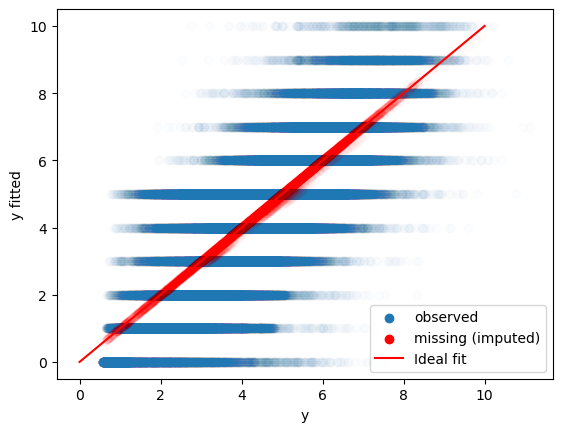

In [113]:
encoded_epsilon, encoded_u = encoder(y=data_true['y'], VARGLLVM_model=model, x=data_true['x'])
_, decoded_mean = model(encoded_epsilon, encoded_u, data_true['x'])

def add_jitter(arr, scale=0):
    return arr + np.random.randn(*arr.shape) * scale

# Extract data
y_without_mask = decoded_mean[~data_true['mask']].detach().numpy()
x_without_mask = data_true['y'][~data_true['mask']].detach().numpy()
y_with_mask = decoded_mean[data_true['mask']].detach().numpy()
x_with_mask = data_true['y'][data_true['mask']].detach().numpy()

# Apply jitter
y_without_mask_jittered = add_jitter(x_without_mask)
x_without_mask_jittered = add_jitter(y_without_mask)
y_with_mask_jittered = add_jitter(x_with_mask)
x_with_mask_jittered = add_jitter(y_with_mask)

# Scatter plot with jitter and alpha transparency
plt.scatter(x_without_mask_jittered, y_without_mask_jittered, alpha=0.01, label="observed")
plt.scatter(x_with_mask_jittered, y_with_mask_jittered, color="red", alpha=0.01, label="missing (imputed)")
plt.plot([0,10],[0,10], color="red", label="Ideal fit")
plt.xlabel("y")
plt.ylabel("y fitted")
# Add a legend with custom marker styles and colors
legend = plt.legend()
for lh in legend.legendHandles:
    lh.set_alpha(1)  # Set legend marker alpha to 1 for visibility
    if isinstance(lh, plt.Line2D):
        lh.set_markersize(10)  # Adjust marker size if it's a Line2D object
    # lh.set_color('black')  # Set marker color to black

plt.show()

## 2. Latent variables

First we look at the latent variables $z$:

Text(0.5, 1.0, 'Evolution of latent variables (z) over time for the first 10 respondents.')

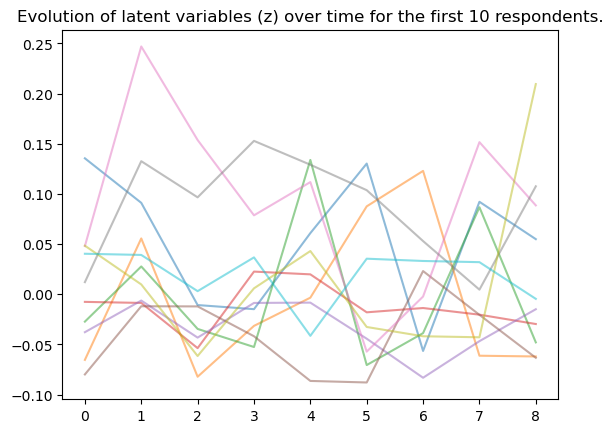

In [114]:
plt.plot(model.VAR1(encoded_epsilon)[:10,:,0].detach().T, alpha=.5)
# plt.plot(torch.mean(model.VAR1(encoded_epsilon)[:,:,0].detach().T, dim=1).unsqueeze(1), color="red")
plt.title("Evolution of latent variables (z) over time for the first 10 respondents.")

Now the random effects $u$:

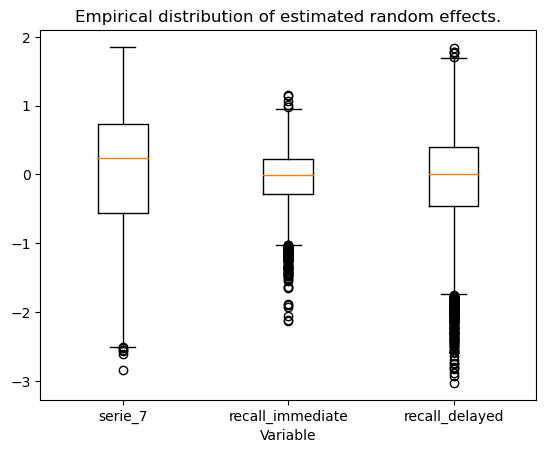

In [115]:
import matplotlib.pyplot as plt

# Your data and code for the boxplot
plt.boxplot(encoded_u[:, 0].T.detach())

# Define the variable names
variable_names = ["serie_7", "recall_immediate", "recall_delayed"]

# Set the x-axis tick labels
plt.xticks(range(1, len(variable_names) + 1), variable_names)

# Label the x-axis and add a title
plt.xlabel("Variable")
plt.title("Empirical distribution of estimated random effects.")

# Show the plot
plt.show()


## 3. Estimated Parameters

In [121]:
for name, par in model.named_parameters():
    print(f'{name}: {par.detach().numpy()}')

print('---\nHelp\n---')
print('variables (columns): serie_7, recall_immediate, recall_delayed')
print('wz are the loadings')
print('wx are the covariates coefficients')
print('covariates (rows of wx) are: age, sex, education')

logvar_z1: [0.]
A: [[0.7321666]]
VAR1_intercept: [0.]
VAR1_slope: [0.]
intercepts: [1.0146257 1.7509478 1.5303397]
wz: [[-0.05157356 -0.05515506  0.05627558]]
wx: [[-0.04795894 -0.08394887 -0.1254789 ]
 [-0.1862539   0.07279865  0.10289335]
 [ 0.0845407   0.03044999  0.04400094]]
logvar_u: [-1.1793724 -1.6445965 -2.1615775]
---
Help
---
variables (columns): serie_7, recall_immediate, recall_delayed
wz are the loadings
wx are the covariates coefficients
covariates (rows of wx) are: age, sex, education
